# Experiments for the Eikonal equation in a d-dimensional ball with different sampling distributions

In [1]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import numpy as np
from time import time as t

import sys
# setting path
sys.path.append('../')

from visualization.plots_disc import plot_2d_proj_disc
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD
from PointSampling.Ball import data_gen_ball, data_gen_ball_unif
from NeuralNetworks.NNs import FCFF_3L,FCFF_4L

#Right-hand-side of the PDE
def f(X):    
    return 1

#Boundary condition
def g(X):    
    return 0


training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,

    'f': f,
    'g': g,
    'c': None,
    
    'beta': 0.,  ## parameter for the +u_i term
    
    'lambda': 1. #weight parameter for the boundary loss
    }

n_experiments_rep = 3

In [2]:
# Dimension of the d-dimensional ball for each experiment
#dim_list = 6*[10]
dim_list = 2*[10]
# Architecture in each experiment
#arch_list = 2*[[40,30], 
#               [40,30,20], 
#               [40,40,40]]
arch_list = [[40,30], 
               [40,30,20], 
               ]
# Sampling distribution: 0 for uniform distribution and 1 for radially uniform distribution
#distr_list = 3*[0] + 3*[1]

distr_list = [0] + [1]

n_experiments = len(dim_list)
radii = [6., 0.]

# Parameters for each experiment
delta_list = [[.7, .3, .1, .01]]*n_experiments
alpha_list = [[2.5, 2., 1., 0.]]*n_experiments
rounds = len(delta_list[0])

N_col_list = [[200]*rounds]*n_experiments
N_b_list = [[80]*rounds]*n_experiments


#num_iterations_list = 2*[[300, 300, 300, 300],
#                       [300, 300, 300, 300],
#                       [300, 500, 800, 1200]]
num_iterations_list = [[3000, 3000, 3000, 3000],
                       [3000, 3000, 3000, 3000],
                       ] 

100%|██████████| 3000/3000 [00:10<00:00, 285.93it/s]


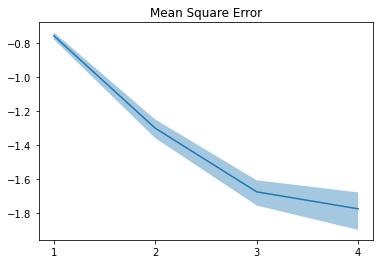

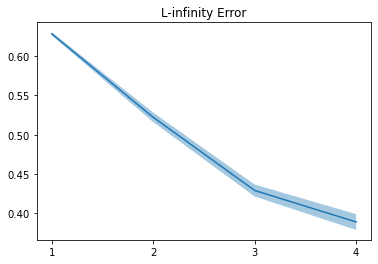

100%|██████████| 3000/3000 [00:13<00:00, 216.98it/s]


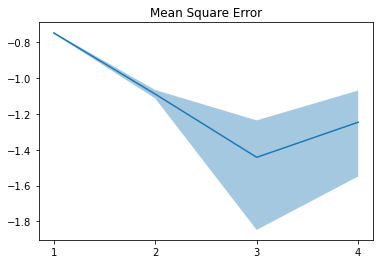

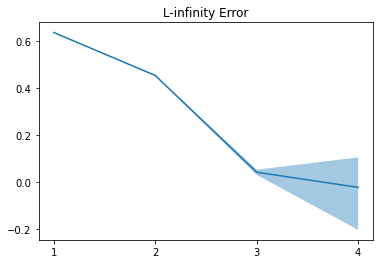

In [3]:
from Training.training import train
from error_test.disc_error import error_ball

MSE_history = torch.zeros([n_experiments, n_experiments_rep, rounds])
L_inf_error_history = torch.zeros([n_experiments, n_experiments_rep, rounds])
run_times = torch.zeros([n_experiments, n_experiments_rep])


for j in range(n_experiments):
        
    for k in range(n_experiments_rep):
        
        if distr_list[j] == 0:
            domain = data_gen_ball_unif(radii, dim_list[j])
        elif distr_list[j] == 1:
            domain = data_gen_ball(radii, dim_list[j])
        else:
            domain == None
        
        if len(arch_list[j]) == 2:        
            NN = FCFF_3L([dim_list[j]] + arch_list[j])
        else:
            NN = FCFF_4L([dim_list[j]] + arch_list[j])
        
        training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .02, momentum = .2)
    
        time = 0.
    
        for i in range(rounds):
    
            training_params['alpha'] = alpha_list[j][i]
            training_params['delta'] = delta_list[j][i]
            
            training_params['n_coloc_points'] = N_col_list[j][i]
            training_params['n_boundary_points'] = N_b_list[j][i]
            training_params['num_iterations'] = num_iterations_list[j][i]
            
            t0 = t()
            total_loss, PDE_loss, boundary_loss = train(NN, domain, training_params)
            time += t() - t0
        
            MC_points = int(1e6) # Number of grid points for comparison with the ground truth
            MSE, L_inf = error_ball(NN, max(radii), MC_points)
        
            MSE_history[j,k,i] = MSE
            L_inf_error_history[j,k,i] = L_inf
    
        run_times[j,k] = time
    
    plt.plot(np.arange(rounds), MSE_history[j].mean(0).log10())
    plt.fill_between(np.arange(rounds),
                     (MSE_history[j].mean(0) - MSE_history[j].std(0)).log10(),
                     (MSE_history[j].mean(0) + MSE_history[j].std(0)).log10(),
                     alpha = .4
                    )
    plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
    plt.title('Mean Square Error')
    plt.show()
    
    plt.plot(np.arange(rounds), L_inf_error_history[j].mean(0).log10())
    plt.fill_between(np.arange(rounds),
                     (L_inf_error_history[j].mean(0) - L_inf_error_history[j].std(0)).log10(),
                     (L_inf_error_history[j].mean(0) + L_inf_error_history[j].std(0)).log10(),
                     alpha = .4
                    )
    plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
    plt.title('L-infinity Error')
    plt.show()

MSE_average = MSE_history.mean(1)
MSE_std = MSE_history.std(1)

Linf_average = L_inf_error_history.mean(1)
Linf_std = L_inf_error_history.std(1)

run_time_avg = run_times.mean(1) 

In [4]:
run_time_avg = run_times.mean(1) 

import pandas as pd
import numpy as np

distr_list_tab = []

for i in range(len(distr_list)):
    if distr_list[i]==0:
        distr_list_tab.append('Unif.')
    elif distr_list[i]==1:
        distr_list_tab.append('Rad.')
    

training_features = pd.DataFrame({'Dimension': dim_list,
                               'Distribution': distr_list_tab,
                               'Architecture': arch_list,
                               'delta': delta_list,
                               'alpha': alpha_list,
                               'N': N_col_list,
                               'N_b': N_b_list,
                               'Iterations': num_iterations_list})

run_T = pd.DataFrame({'Runtime (s)': np.array(run_time_avg)}).astype('int')

results_MSE = pd.DataFrame(np.array(MSE_average))
results_Linf = pd.DataFrame(np.array(Linf_average))


display('Mean Square Error', training_features.join(results_MSE).join(run_T).transpose())
display('L-infinity Error', training_features.join(results_Linf).join(run_T).transpose())


#One table

MSE = np.array(MSE_history[:,:,-1])
L_inf_error = np.array(L_inf_error_history[:,:,-1])

data_MSE = pd.DataFrame(MSE.transpose())
means_MSE = data_MSE.mean()
stds_MSE = data_MSE.std()

data_Linf = pd.DataFrame(L_inf_error.transpose())
means_Linf = data_Linf.mean()
stds_Linf = data_Linf.std()

summary_df = pd.DataFrame({
    'MSE': means_MSE.round(3).astype(str) + ' ± ' + stds_MSE.round(3).astype(str),
    'L_inf': means_Linf.round(3).astype(str) + ' ± ' + stds_Linf.round(3).astype(str)
})

display(training_features.join(summary_df).join(run_T).transpose())

'Mean Square Error'

,0,1
Dimension,10,10
Distribution,Unif.,Rad.
Architecture,"[40, 30]","[40, 30, 20]"
delta,"[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]"
alpha,"[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]"
0,0.174114,0.178034
1,0.0500167,0.0812425


'L-infinity Error'

,0,1
Dimension,10,10
Distribution,Unif.,Rad.
Architecture,"[40, 30]","[40, 30, 20]"
delta,"[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]"
alpha,"[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]"
0,4.24915,4.3346
1,3.32734,2.84112


,0,1
Dimension,10,10
Distribution,Unif.,Rad.
Architecture,"[40, 30]","[40, 30, 20]"
delta,"[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]"
alpha,"[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]"
MSE,0.017 ± 0.004,0.057 ± 0.028
L_inf,2.449 ± 0.057,0.947 ± 0.324


In [5]:
display(training_features.join(summary_df).join(run_T).transpose().to_latex())

'\\begin{tabular}{lll}\n\\toprule\n{} &                         0 &                         1 \\\\\n\\midrule\nDimension    &                        10 &                        10 \\\\\nDistribution &                     Unif. &                      Rad. \\\\\nArchitecture &                  [40, 30] &              [40, 30, 20] \\\\\ndelta        &     [0.7, 0.3, 0.1, 0.01] &     [0.7, 0.3, 0.1, 0.01] \\\\\nalpha        &      [2.5, 2.0, 1.0, 0.0] &      [2.5, 2.0, 1.0, 0.0] \\\\\nN            &      [200, 200, 200, 200] &      [200, 200, 200, 200] \\\\\nN\\_b          &          [80, 80, 80, 80] &          [80, 80, 80, 80] \\\\\nIterations   &  [3000, 3000, 3000, 3000] &  [3000, 3000, 3000, 3000] \\\\\nMSE          &             0.017 ± 0.004 &             0.057 ± 0.028 \\\\\nL\\_inf        &             2.449 ± 0.057 &             0.947 ± 0.324 \\\\\nRuntime (s)  &                        37 &                        54 \\\\\n\\bottomrule\n\\end{tabular}\n'

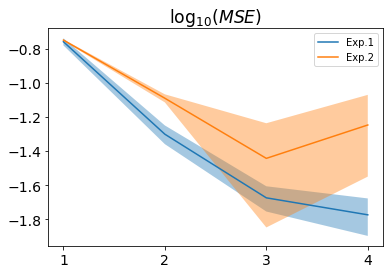

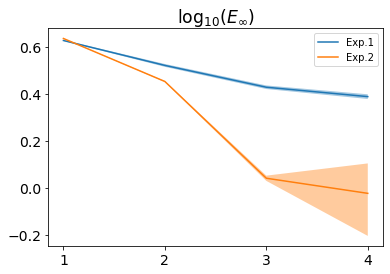

In [6]:
from mpl_toolkits.axes_grid1 import host_subplot

ax = host_subplot(111)
for i in range(MSE_history.shape[0]):
    x = np.arange(rounds) + 1
    
    text = 'Exp.' + str(i+1)
    
    ax.plot(x, 
            MSE_history[i].mean(0).log10(), 
            label = text)
    ax.fill_between(x,
                   (MSE_history[i].mean(0) - MSE_history[i].std(0)).log10(),
                   (MSE_history[i].mean(0) + MSE_history[i].std(0)).log10(),
                   alpha = .4)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
plt.legend()
plt.show()

ax = host_subplot(111)
for i in range(L_inf_error_history.shape[0]):
    L_inf_log10 = torch.log10(L_inf_error_history[i])
    
    text = 'Exp.' + str(i+1)
    
    ax.plot(x,
            L_inf_error_history[i].mean(0).log10(), 
            label = text)
    ax.fill_between(x,
                   (L_inf_error_history[i].mean(0) - L_inf_error_history[i].std(0)).log10(),
                   (L_inf_error_history[i].mean(0) + L_inf_error_history[i].std(0)).log10(),
                   alpha = .4)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')
plt.legend()
plt.show()